In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [38]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, file_list, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image

# Define transformations to apply to your images
transform = transforms.Compose([
    # transforms.Resize((200, 200)), # not necessary, since images are already 200x200
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

In [39]:
# perform train test split
# iterate through all subfolders (rex, tri, etc)
current_dir = os.getcwd()
project_dir = os.path.dirname(current_dir)
images_dir = os.path.join(project_dir, 'augmented_images')

file_list = []

for folder in os.listdir(images_dir):
    if folder == 'mis':
        continue
    folder_fp = os.path.join(images_dir, folder) 
    for img in os.listdir(folder_fp):
        file_list.append(os.path.join(folder_fp, img))

train_indices, val_indices = train_test_split(range(len(file_list)), test_size=0.2, random_state=42)
train_files = [file_list[i] for i in train_indices]
validation_files = [file_list[i] for i in val_indices]

In [48]:
current_dir = os.getcwd()
project_dir = os.path.dirname(current_dir)
images_dir = os.path.join(project_dir, 'augmented_images')

training = CustomDataset(file_list = train_files, root_dir = images_dir, transform=transform)
validation = CustomDataset(file_list = validation_files, root_dir = images_dir, transform=transform)

# Create a dataloader
batch_size = 32
dataloader = DataLoader(training, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation, batch_size=batch_size, shuffle=True)

In [49]:
# autoencoder code borrowed from patrickloeber: https://github.com/patrickloeber/pytorch-examples/blob/master/Autoencoder.ipynb

class Conv_AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__() 
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 4, stride = 3, padding = 1), # 32, 16, 67, 67
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride = 2, padding = 1),# 32, 32, 34, 34
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride = 2, padding = 1), # 32, 32, 17, 17
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 17 * 17, 3000),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3000, 32 * 17 * 17),
            nn.ReLU(),
            nn.Unflatten(dim = 1, unflattened_size=(32, 17, 17)),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride = 2, padding = 1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride = 2, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 4, stride = 3, padding = 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [50]:
model = Conv_AutoEncoder()
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-4, 
                             weight_decay=1e-6)

In [51]:
# Point to training loop video
num_epochs = 50
outputs = []
for epoch in range(num_epochs):

    training_loss = 0
    for img in dataloader:
        img = img.to(device)
        # img = img.reshape(-1, 200*200)
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        training_loss += loss.item() * img.size(0)  # Accumulate the training loss

    
    validation_loss = 0
    for img in validation_loader:
        img = img.to(device)
        # img = img.reshape(-1, 200*200)
        recon = model(img)
        loss = criterion(recon, img)

        validation_loss += loss.item() * img.size(0)  # Accumulate the training loss

    # Compute average losses
    training_loss /= len(dataloader.dataset)
    validation_loss /= len(validation_loader.dataset)


    print(f'Epoch:{epoch+1}, Training Loss:{training_loss:.4f}, Validation Loss:{validation_loss:.4f}')

    if epoch % 50 == 0:
        outputs.append((epoch, img, recon))

Epoch:1, Training Loss:0.1277, Validation Loss:0.0382
Epoch:2, Training Loss:0.0276, Validation Loss:0.0252
Epoch:3, Training Loss:0.0215, Validation Loss:0.0183
Epoch:4, Training Loss:0.0182, Validation Loss:0.0180
Epoch:5, Training Loss:0.0179, Validation Loss:0.0175
Epoch:6, Training Loss:0.0167, Validation Loss:0.0159
Epoch:7, Training Loss:0.0151, Validation Loss:0.0145
Epoch:8, Training Loss:0.0139, Validation Loss:0.0134
Epoch:9, Training Loss:0.0128, Validation Loss:0.0124
Epoch:10, Training Loss:0.0119, Validation Loss:0.0117
Epoch:11, Training Loss:0.0111, Validation Loss:0.0110
Epoch:12, Training Loss:0.0105, Validation Loss:0.0105
Epoch:13, Training Loss:0.0099, Validation Loss:0.0101
Epoch:14, Training Loss:0.0094, Validation Loss:0.0097
Epoch:15, Training Loss:0.0090, Validation Loss:0.0094
Epoch:16, Training Loss:0.0087, Validation Loss:0.0092
Epoch:17, Training Loss:0.0084, Validation Loss:0.0089
Epoch:18, Training Loss:0.0081, Validation Loss:0.0087
Epoch:19, Training 

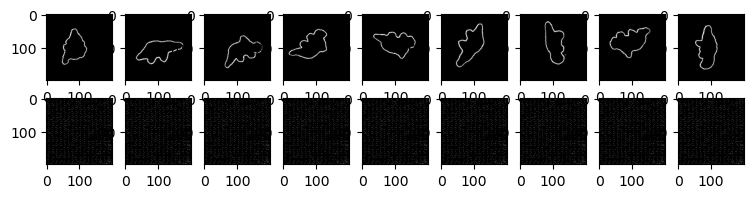

In [53]:
imgs = 0
for k in range(len(outputs)):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1]
    recon = outputs[k][2]
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item.view(200, 200).cpu().detach().numpy())
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item.view(200, 200).cpu().detach().numpy())

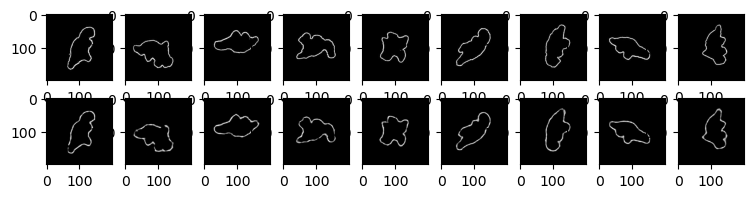

In [110]:
test = {}
for img in validation_loader:
    img = img.to(device)
    # img = img.reshape(-1, 200*200)
    recon = model(img)
    test['og'] = img
    test['recon'] = recon

plt.figure(figsize=(9, 2))
plt.gray()
imgs = test['og']
recon = test['recon']
for i, item in enumerate(imgs):
    if i >= 9: break
    plt.subplot(2, 9, i+1)
    # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
    # item: 1, 28, 28
    plt.imshow(item.view(200, 200).cpu().detach().numpy())
        
for i, item in enumerate(recon):
    if i >= 9: break
    plt.subplot(2, 9, 9+i+1) # row_length + i + 1
    # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
    # item: 1, 28, 28
    plt.imshow(item.view(200, 200).cpu().detach().numpy())

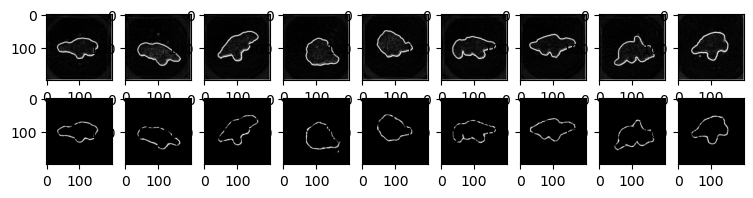

In [107]:
misformed_images_dir = os.path.join(project_dir, 'images')

mis_dir = os.path.join(misformed_images_dir, 'mis')
mis_files = []

for img in os.listdir(mis_dir):
    mis_files.append(os.path.join(mis_dir, img))

misformed = CustomDataset(file_list = mis_files, root_dir = images_dir, transform=transform)
misformed_loader = DataLoader(misformed, batch_size=batch_size, shuffle=False)

anomaly_test = {}
for img in misformed_loader:
    img = img.to(device)
    # img = img.reshape(-1, 200*200)
    recon = model(img)
    anomaly_test['og'] = img
    anomaly_test['recon'] = recon


plt.figure(figsize=(9, 2))
plt.gray()
imgs = anomaly_test['og']
recon = anomaly_test['recon']
for i, item in enumerate(imgs):
    if i >= 9: break
    plt.subplot(2, 9, i+1)
    # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
    # item: 1, 28, 28
    plt.imshow(item.view(200, 200).cpu().detach().numpy())
        
for i, item in enumerate(recon):
    if i >= 9: break
    plt.subplot(2, 9, 9+i+1) # row_length + i + 1
    # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
    # item: 1, 28, 28
    plt.imshow(item.view(200, 200).cpu().detach().numpy())

In [111]:
og = 0
recon = 1

for i in range(22):
    original = anomaly_test['og'][i][0]
    recon = anomaly_test['recon'][i][0]
    mse = F.mse_loss(original, recon)

    print(mse)

tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0287, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0277, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0253, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0270, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0279, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0274, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0270, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0275, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0342, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0367, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0329, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0258, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0407, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0361, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0283, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0252, device='cuda:0', grad_fn=

In [113]:
og = 0
recon = 1

for i in range(22):
    original = test['og'][i][0]
    recon = test['recon'][i][0]
    mse = F.mse_loss(original, recon)

    print(mse)

tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0058, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0031, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0031, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0032, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0066, device='cuda:0', grad_fn=

In [102]:
og = 0
recon = 1

for i in range(22):
    original = anomaly_test[0][0][i][0]
    recon = anomaly_test[0][1][i][0]
    mse = F.mse_loss(original, recon)

    print(mse)

tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0287, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0277, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0253, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0270, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0279, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0274, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0270, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0275, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0342, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0367, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0329, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0258, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0407, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0361, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0283, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0252, device='cuda:0', grad_fn=

In [106]:
anomaly_test[0][0].shape

torch.Size([22, 1, 200, 200])

In [72]:
torch.save(model.state_dict(), 'validated_conv_autoencoder_50_epochs.pth')